In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout 
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

from sklearn.metrics import classification_report,confusion_matrix

import tensorflow as tf

import cv2
import os

import numpy as np

In [3]:
labels = ['Non Oil Spill','Oil Spill']
img_size = 150
def get_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img))[...,::-1] #convert BGR to RGB format
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

In [4]:
train = get_data("/content/drive/MyDrive/new data/Spill_Data/Train")
test = get_data("/content/drive/MyDrive/new data/Spill_Data/Test")
val=get_data("/content/drive/MyDrive/new data/Spill_Data/Test")

<ipython-input-3-08b0147452da>:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(data)


In [5]:
import os
len(os.listdir("/content/drive/MyDrive/new data/Spill_Data/Train/Oil Spill"))

168

In [6]:
len(os.listdir("/content/drive/MyDrive/new data/Spill_Data/Train/Non Oil Spill"))

132

In [7]:
len(os.listdir("/content/drive/MyDrive/new data/Spill_Data/Test/Oil Spill"))

70

In [8]:
len(os.listdir("/content/drive/MyDrive/new data/Spill_Data/Test/Non Oil Spill"))

42

In [9]:
len(os.listdir("/content/drive/MyDrive/new data/Spill_Data/Test/Oil Spill"))

FileNotFoundError: ignored

In [ ]:
len(os.listdir("/content/drive/MyDrive/new data/Spill_Data/Validation/Non Oil Spill"))

Text(0.5, 1.0, 'Non Oil Spill')

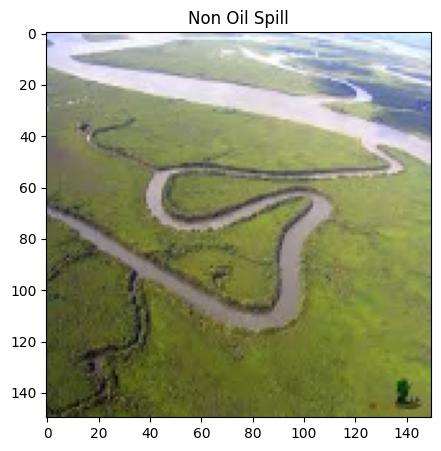

In [16]:
plt.figure(figsize = (5,5))
plt.imshow(train[2][0])
plt.title(labels[train[0][1]])

Text(0.5, 1.0, 'Oil Spill')

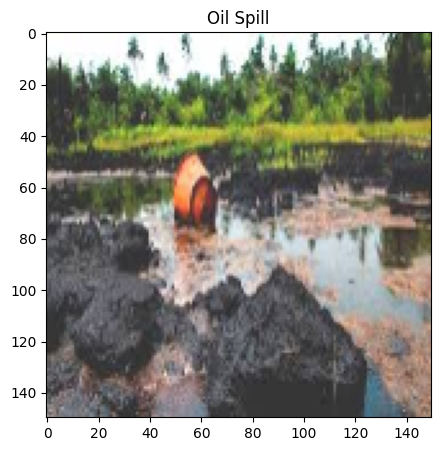

In [11]:
plt.figure(figsize = (5,5))
plt.imshow(train[-1][0])
plt.title(labels[train[-1][1]])

In [12]:
x_train = []
y_train = []
x_val = []
y_val = []
x_test = []
y_test = []

for feature, label in train:
  x_train.append(feature)
  y_train.append(label)

for feature, label in val:
  x_val.append(feature)
  y_val.append(label)

for feature, label in test:
  x_test.append(feature)
  y_test.append(label)

# Normalize the data
x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255
x_test=np.array(x_test)/255

x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

x_test.reshape(-1, img_size, img_size, 1)
y_test = np.array(y_test)

In [13]:
print("x_train:",x_train.shape)
print("y_train:",y_train.shape)
print("x_test:",x_test.shape)
print("y_test:",y_test.shape)
print("x_val:",x_val.shape)
print("y_val:",y_val.shape)

x_train: (300, 150, 150, 3)
y_train: (300,)
x_test: (112, 150, 150, 3)
y_test: (112,)
x_val: (112, 150, 150, 3)
y_val: (112,)


In [17]:
datagen = ImageDataGenerator(
       featurewise_center=False,  
       samplewise_center=False,  
       featurewise_std_normalization=False,  
       samplewise_std_normalization=False,  
       zca_whitening=False,  
       rotation_range = 90, 
       zoom_range = 0.5, 
       width_shift_range=0.2,  
       height_shift_range=0.2,  
       horizontal_flip = True,  
       
)
datagen.fit(x_train)
datagen.fit(x_val)
datagen.fit(x_test)

In [18]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.optimizers import RMSprop,Adam

In [19]:
pretrained_model3=InceptionV3(input_shape=(150,150,3),
                             include_top=False,
                             weights='imagenet')
#freazing the trained layers
for layers in pretrained_model3.layers:
    layers.trainable=False

In [20]:
last_layer=pretrained_model3.get_layer('mixed10')
last_output = last_layer.output

In [21]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.959):
      print("\nReached 99.9% accuracy so cancelling training!")
      self.model.stop_training = True

In [22]:
optimizers = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)

In [23]:
x=tf.keras.layers.Flatten()(last_output)

x=tf.keras.layers.Dense(512,activation='relu')(x)
x=tf.keras.layers.Dropout(0.2)(x)

x=tf.keras.layers.Dense(256,activation='relu')(x)
x=tf.keras.layers.Dropout(0.2)(x)

x=tf.keras.layers.Dense(2,activation='sigmoid')(x)
#x=tf.keras.layers.Flatten()
model3=tf.keras.Model(pretrained_model3.input,x)

model3.compile(optimizer=optimizers,
              loss='sparse_categorical_crossentropy',
               metrics=['accuracy'])
model3.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 74, 74, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 74, 74, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                              

In [24]:
print(len(model3.layers))

317


In [25]:
history=model3.fit(x_train,y_train,validation_data=(x_val,y_val),epochs=10,batch_size=64,shuffle=True)

Epoch 1/10
5/5 [==============================] - 29s 5s/step - loss: 8.6223 - accuracy: 0.6167 - val_loss: 5.3209 - val_accuracy: 0.6339
Epoch 2/10
5/5 [==============================] - 24s 5s/step - loss: 2.5768 - accuracy: 0.7200 - val_loss: 0.1864 - val_accuracy: 0.9375
Epoch 3/10
5/5 [==============================] - 19s 4s/step - loss: 0.8862 - accuracy: 0.8733 - val_loss: 0.6545 - val_accuracy: 0.8393
Epoch 4/10
5/5 [==============================] - 19s 4s/step - loss: 0.5694 - accuracy: 0.9000 - val_loss: 0.0551 - val_accuracy: 0.9911
Epoch 5/10
5/5 [==============================] - 19s 4s/step - loss: 0.1207 - accuracy: 0.9733 - val_loss: 0.3300 - val_accuracy: 0.9464
Epoch 6/10
5/5 [==============================] - 18s 4s/step - loss: 0.1152 - accuracy: 0.9700 - val_loss: 0.0631 - val_accuracy: 0.9643
Epoch 7/10
5/5 [==============================] - 18s 4s/step - loss: 0.1628 - accuracy: 0.9867 - val_loss: 0.1768 - val_accuracy: 0.9554
Epoch 8/10
5/5 [==================

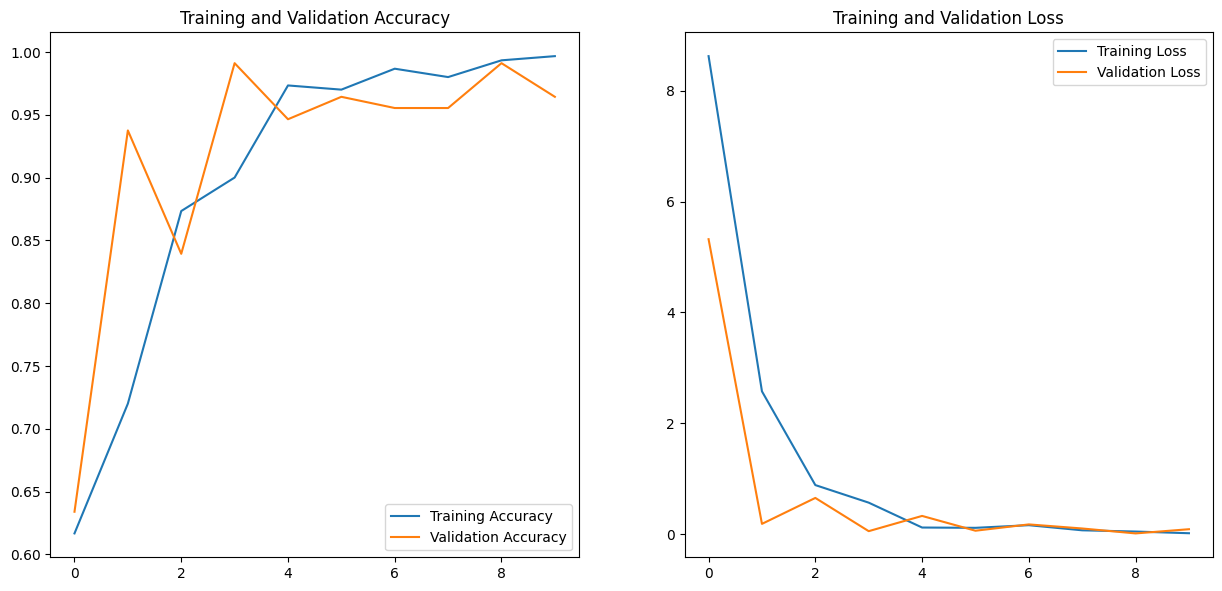

In [26]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(10)

plt.figure(figsize=(15,15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


Text(0, 0.5, 'Loss')

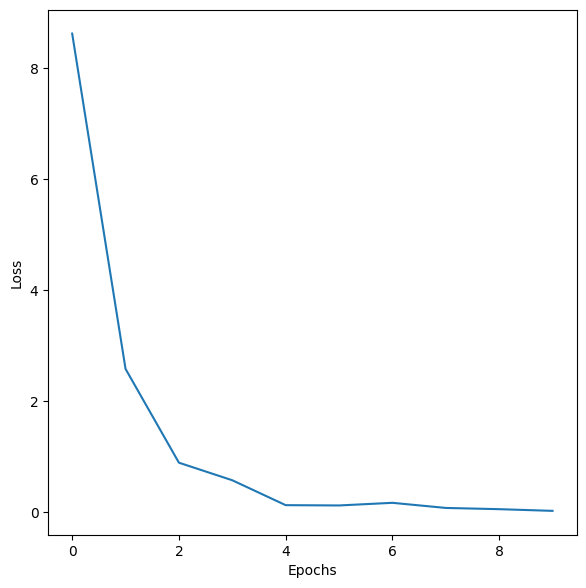

In [27]:
loss = history.history['loss']
epochs_range = range(10)
plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, loss, label='loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

In [28]:
predictions = model3.predict(x_test)
pred=np.argmax(predictions,axis=1)
pred = pred.reshape(1,-1)[0]
print(classification_report(y_test,pred, target_names = ['Non Oil Spill(Class 0)','Oil Spill (Class 1)']))

4/4 [==============================] - 8s 1s/step
                        precision    recall  f1-score   support

Non Oil Spill(Class 0)       0.91      1.00      0.95        42
   Oil Spill (Class 1)       1.00      0.94      0.97        70

              accuracy                           0.96       112
             macro avg       0.96      0.97      0.96       112
          weighted avg       0.97      0.96      0.96       112



In [29]:
model3.evaluate(x_test,y_test,batch_size=64)

2/2 [==============================] - 5s 2s/step - loss: 0.0902 - accuracy: 0.9643


[0.09019190818071365, 0.9642857313156128]

In [30]:
import numpy as np
import keras
from tensorflow.keras.applications.imagenet_utils import decode_predictions
import skimage.io 
import skimage.segmentation
import copy
import sklearn
import sklearn.metrics
from sklearn.linear_model import LinearRegression
import warnings

print('Notebook running: keras ', keras.__version__)
np.random.seed(222)

Notebook running: keras  2.12.0


In [31]:
warnings.filterwarnings('ignore') 
inceptionV3_model = keras.applications.inception_v3.InceptionV3() #Load pretrained model

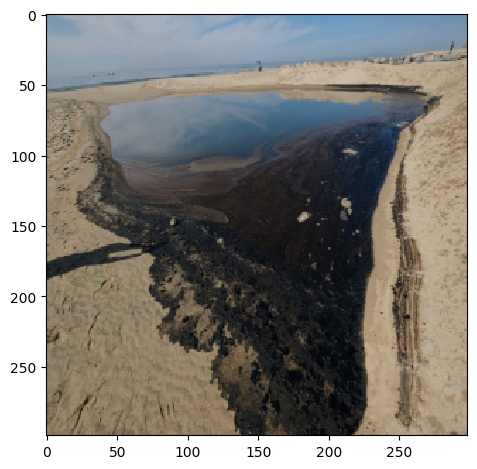

In [32]:
Xi = skimage.io.imread("/content/drive/MyDrive/hi/LIME_INCEPTION/train/Oil Spill/OilSpill_00137.jpg")
Xi = skimage.transform.resize(Xi, (299,299)) 
Xi = (Xi - 0.5)*2 #Inception pre-processing
skimage.io.imshow(Xi/2+0.5) # Show image before inception preprocessing

In [33]:
np.random.seed(222)
preds = inceptionV3_model.predict(Xi[np.newaxis,:,:,:])
decode_predictions(preds)[0] #Top 5 classes


1/1 [==============================] - 2s 2s/step


[('n09421951', 'sandbar', 0.5739732),
 ('n09472597', 'volcano', 0.10988318),
 ('n09428293', 'seashore', 0.10692172),
 ('n09246464', 'cliff', 0.05519975),
 ('n09399592', 'promontory', 0.02270713)]

In [34]:
top_pred_classes = preds[0].argsort()[-5:][::-1]
top_pred_classes                #Index of top 5 classes

array([977, 980, 978, 972, 976])

In [35]:
superpixels = skimage.segmentation.quickshift(Xi, kernel_size=4,max_dist=200, ratio=0.2)
num_superpixels = np.unique(superpixels).shape[0]
num_superpixels

65

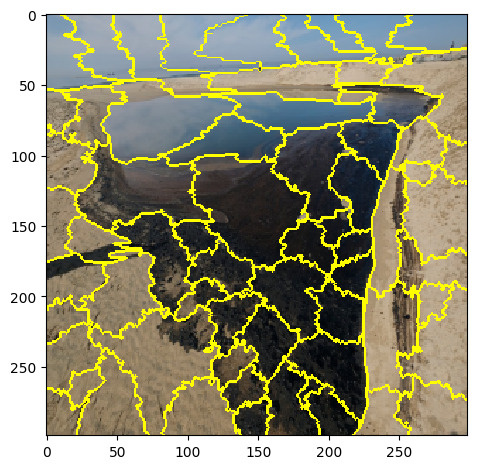

In [36]:
skimage.io.imshow(skimage.segmentation.mark_boundaries(Xi/2+0.5, superpixels))

In [37]:
num_perturb = 150
perturbations = np.random.binomial(1, 0.5, size=(num_perturb, num_superpixels))
perturbations[0] #Show example of perturbation

array([1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1,
       0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1])

In [38]:
def perturb_image(img,perturbation,segments):
  active_pixels = np.where(perturbation == 1)[0]
  mask = np.zeros(segments.shape)
  for active in active_pixels:
      mask[segments == active] = 1 
  perturbed_image = copy.deepcopy(img)
  perturbed_image = perturbed_image*mask[:,:,np.newaxis]
  return perturbed_image

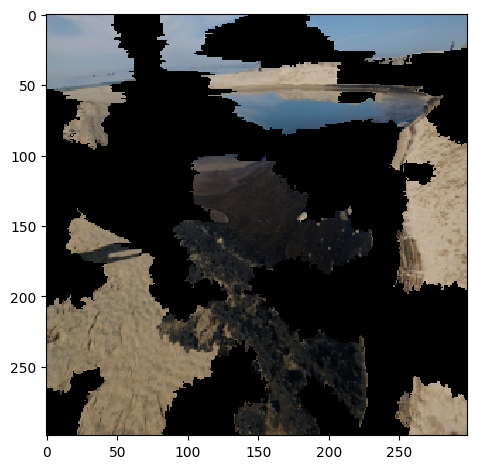

In [39]:
skimage.io.imshow(perturb_image(Xi/2+0.5,perturbations[0],superpixels))

In [40]:
predictions = []
for pert in perturbations:
  perturbed_img = perturb_image(Xi,pert,superpixels)
  pred = inceptionV3_model.predict(perturbed_img[np.newaxis,:,:,:])
  predictions.append(pred)

predictions = np.array(predictions)
predictions.shape

1/1 [==============================] - 0s 311ms/step


(150, 1, 1000)

In [41]:
original_image = np.ones(num_superpixels)[np.newaxis,:] #Perturbation with all superpixels enabled 
distances = sklearn.metrics.pairwise_distances(perturbations,original_image, metric='cosine').ravel()
distances.shape

(150,)

In [42]:
kernel_width = 0.25
weights = np.sqrt(np.exp(-(distances**2)/kernel_width**2)) #Kernel function
weights.shape

(150,)

In [43]:
class_to_explain = top_pred_classes[0]
simpler_model = LinearRegression()
simpler_model.fit(X=perturbations, y=predictions[:,:,class_to_explain], sample_weight=weights)
coeff = simpler_model.coef_[0]
coeff

array([-0.00984487,  0.00066199,  0.02164372,  0.01686733,  0.01688841,
        0.01251968, -0.00084372,  0.00485313,  0.00504094, -0.00795689,
        0.01845992,  0.00485152,  0.00279912,  0.00856   ,  0.01131309,
        0.00087443, -0.01984226,  0.01075902,  0.00726292,  0.01061137,
        0.00739661,  0.00320999, -0.0199156 , -0.00648499,  0.00468658,
       -0.01497569,  0.00454902,  0.01350224, -0.00135891,  0.00907954,
        0.00277975,  0.00315223, -0.01150639, -0.01226017,  0.00936429,
        0.00698053, -0.00917819,  0.01527011, -0.00645321,  0.00987402,
        0.00373243, -0.00776619,  0.00871095,  0.00433811, -0.00171848,
        0.00433706, -0.00243939, -0.01117446,  0.01699684, -0.00852307,
        0.00078976, -0.00980712, -0.00053353, -0.00562996,  0.00146676,
       -0.00500596, -0.00791613, -0.00243506,  0.00361672, -0.00718052,
        0.01362282, -0.00271799,  0.0003021 ,  0.00020957, -0.00781964])

In [44]:
num_top_features = 4
top_features = np.argsort(coeff)[-num_top_features:] 
top_features

array([ 4, 48, 10,  2])

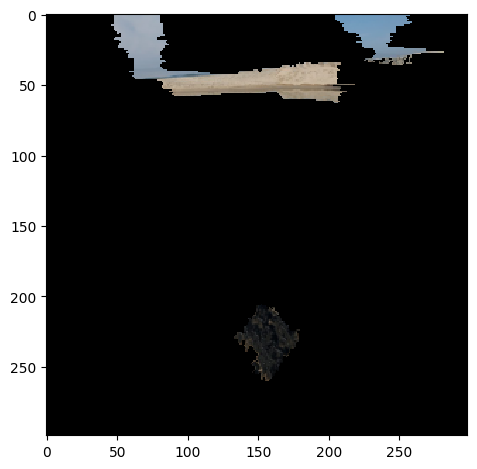

In [45]:
mask = np.zeros(num_superpixels) 
mask[top_features]= True #Activate top superpixels
skimage.io.imshow(perturb_image(Xi/2+0.5,mask,superpixels) )
